In [1]:
# import stuff
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os

import scipy
from scipy import signal
import h5py, time
from iminuit import Minuit, describe
from pprint import pprint # we use this to pretty print some stuff later
import glob
import pandas as pd
import sys
sys.path.append('/home/analysis_user/New_trap_code/Tools/')
import BeadDataFile
from discharge_tools import *
from AnaUtil import *
from bisect import bisect_left
from tqdm import tqdm
import datetime as dt
plt.rcParams["figure.figsize"] = (16,12)
plt.rcParams["font.size"] = 24
plt.rcParams['xtick.labelsize'] = "small"
plt.rcParams['ytick.labelsize'] = 36

In [2]:
Year = "2019"
Month = "12"
Day = "15"
BeadNumber =1
folder_basic = r"/data/new_trap/"+ Year + Month + Day + "/Bead"+str(BeadNumber)
folder_processed = r"/data/new_trap_processed/harmonics_processed/"+ Year + Month + Day + "/Bead"+str(BeadNumber)


In [416]:
measurements=[68]*2+[330]+[355]*2+[358]*2+[362]+[380]*6+[385]*17+[388]*13+[390]*3+[393]
frequency_list = [[13]*2]+[[13]]+[[7]+[13]]+[[13]*2] + [[7]] + [[13]*6] + [[13]*8 + [7]*2 + [13]*7]+[[13]*3+[7]*2+[13]+[7]+[3]+[7]+[3]+[13]*3]+[[7]*3]+[[7]]

In [4]:
counter = 0
for element in np.unique(measurements):
    counter +=1
    processor_new_trap(folder_basic,[element]*measurements.count(element),frequency_list[counter-1],max_file=1000,save_file=True)

The used distance is 68 and the used frequency is 13


  3%|▎         | 3/100 [00:00<00:03, 29.36it/s]

100  files in folder
100  files loaded


100%|██████████| 100/100 [00:02<00:00, 45.75it/s]


File could not be saved, probably exists.
The used distance is 68 and the used frequency is 13


  5%|▌         | 5/100 [00:00<00:02, 42.52it/s]

100  files in folder
100  files loaded


100%|██████████| 100/100 [00:02<00:00, 42.07it/s]


File could not be saved, probably exists.
The used distance is 330 and the used frequency is 13


KeyboardInterrupt: 

In [417]:
df_list_hack = file_loader_processed(folder_processed,measurements)

/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking68/harmonics_processed_basic_Shaking68_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking68/harmonics_processed_basic_Shaking68_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking330/harmonics_processed_basic_Shaking330_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking355/harmonics_processed_basic_Shaking355_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking355/harmonics_processed_basic_Shaking355_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking358/harmonics_processed_basic_Shaking358_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking358/harmonics_processed_basic_Shaking358_1.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking362/harmonics_processed_basic_Shaking362_0.pkl
/data/new_trap_processed/harmonics_processed/20191215/Bead1/Shaking380/harmonics_processed_b

In [418]:
# little hack to delete the incomplete shaking390_1
df_list = df_list_hack[0:45]
df_list.append(df_list_hack[-2])
df_list.append(df_list_hack[-1])


In [419]:
# make a fast sanity check of the data sets

harmonic = 1
std_list_list = []
std_list =[]
for j in range(len(df_list)):
    std_list = []
    df=df_list[j]
    for i in range(len(df)):
        std_list.append(df["amplitude_z"][i][harmonic-1])  
    ratio = (np.std(std_list)/np.mean(std_list))    
    if(ratio>1):print("Anomalous event probable in data set %d with a ratio of %2.2f" %(j,ratio))


Anomalous event probable in data set 2 with a ratio of 22.20
Anomalous event probable in data set 3 with a ratio of 1.33
Anomalous event probable in data set 5 with a ratio of 1.23
Anomalous event probable in data set 8 with a ratio of 1.13
Anomalous event probable in data set 9 with a ratio of 1.29
Anomalous event probable in data set 14 with a ratio of 1.06
Anomalous event probable in data set 15 with a ratio of 1.06
Anomalous event probable in data set 22 with a ratio of 1.02
Anomalous event probable in data set 23 with a ratio of 1.05
Anomalous event probable in data set 27 with a ratio of 1.12
Anomalous event probable in data set 37 with a ratio of 1.10
Anomalous event probable in data set 39 with a ratio of 1.42
Anomalous event probable in data set 40 with a ratio of 9.95
Anomalous event probable in data set 44 with a ratio of 1.46


In [8]:
norm_x =1/(9.242334036366173e-13 * np.sqrt(5))
norm_z =1/(2.78059791556146e-19 * np.sqrt(5))



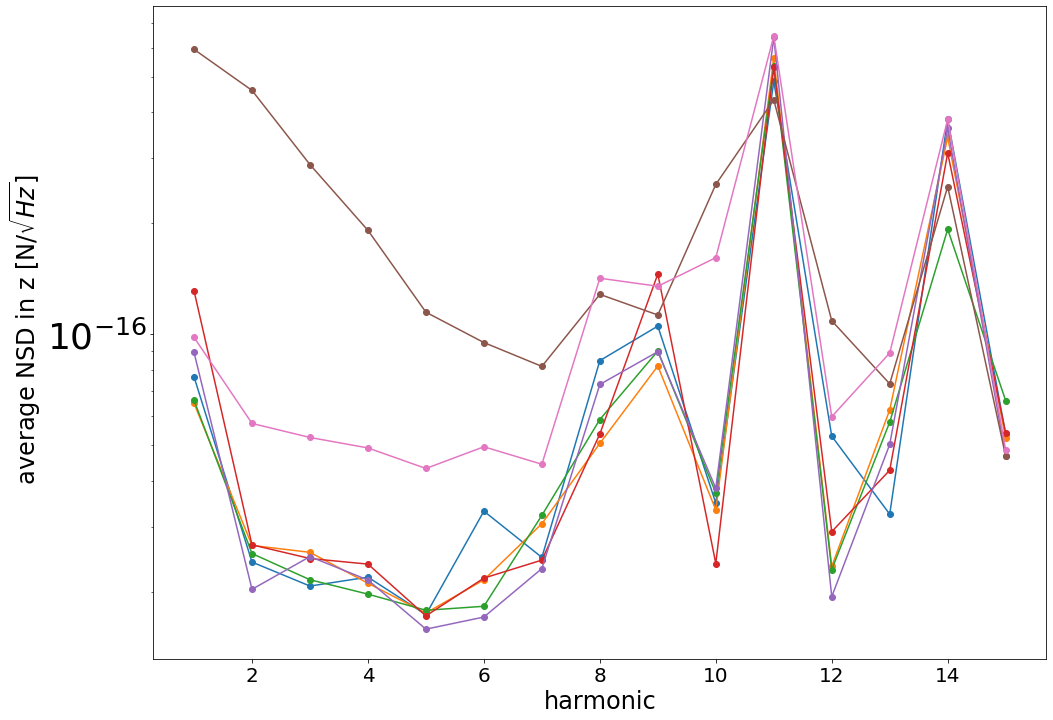

In [430]:
df_sublist = df_list[24:31]
#df_sublist = df_list[3:7]
#df_sublist.append(df_list[6][0:40])
#df_sublist.append(df_list[6][40:100])

axis = "z"
if(axis=="x"):norm_factor=norm_x
if(axis=="z"):norm_factor=norm_z    
distance = 385
output_file= "Results/Dalen_20200106/%sforce_shield_influence_%d.png" %(axis,distance)
save_file = True
plot_basic_harmonic_sum(df_sublist,axis=axis,norm_factor=norm_factor,no_harmonics=15,label="Z position in um",var_of_interest="attractor_position_z",output_file=output_file,legend=False,save_file=save_file)


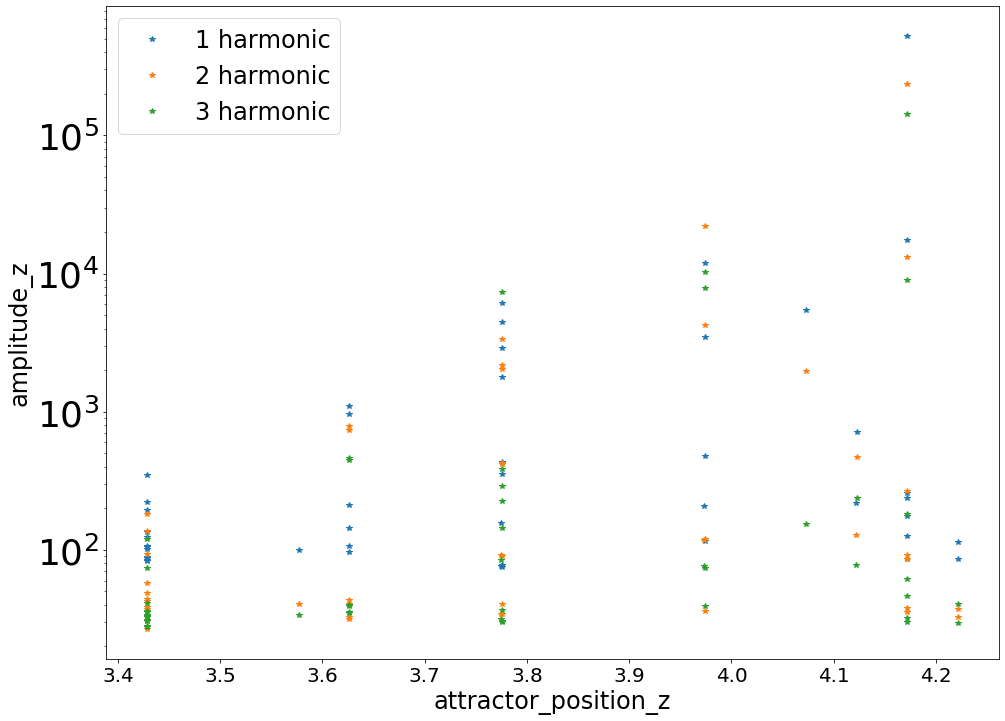

In [382]:
var_of_int1 ="attractor_position_z"
var_of_int2 = "amplitude_z"
for j in np.arange(0,3,1):    
    z_attr_pos_list = []
    mean_force_z_single_harmonic = []
    for i in range(len(df_list)):
        z_attr_pos_list.append(np.mean(df_list[i][var_of_int1]))
        mean_force_z_single_harmonic.append(np.mean(df_list[i][var_of_int2])[j])
    plt.plot(z_attr_pos_list,mean_force_z_single_harmonic,linestyle="",marker="*",label="%d harmonic"%(j+1))
    plt.yscale("log")
    #plt.xscale("log")
    plt.ylabel(var_of_int2)
    plt.xlabel(var_of_int1)
    plt.legend()
#plt.savefig("Results/Dalen_20200106/2d_%s_vs%s_all_datasets.png" %(var_of_int1,var_of_int2), dpi=300, bbox_inches="tight")
plt.show()    


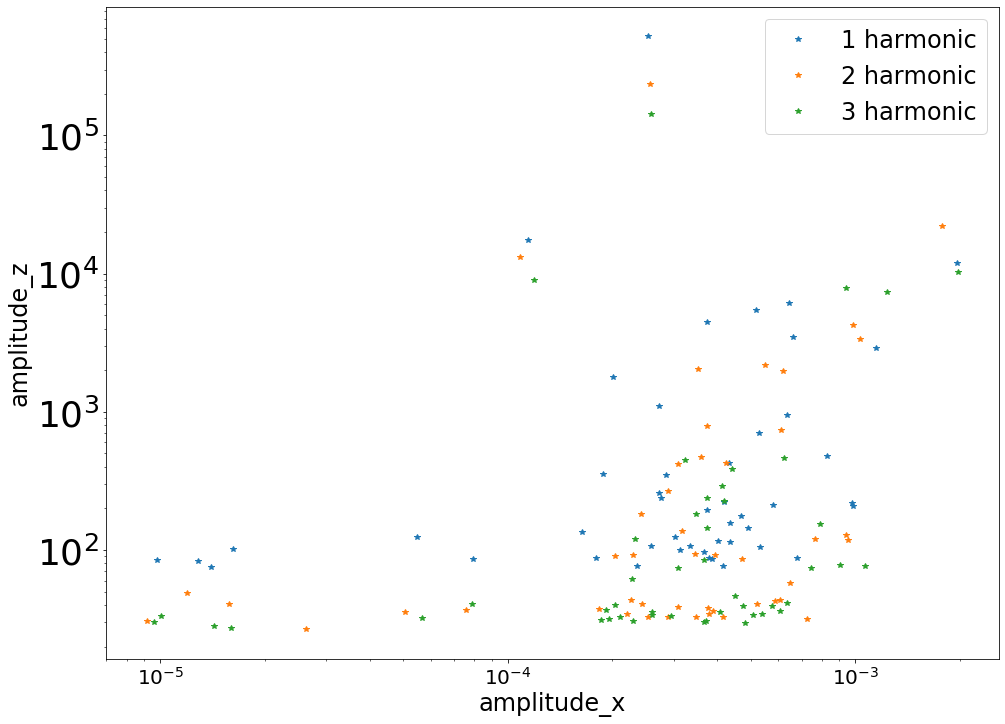

In [287]:
var_of_int1 ="amplitude_x"
var_of_int2 = "amplitude_z"
for j in np.arange(0,3,1):    
    z_attr_pos_list = []
    mean_force_z_single_harmonic = []
    for i in range(len(df_list)):
        z_attr_pos_list.append(np.mean(df_list[i][var_of_int1][j]))
        mean_force_z_single_harmonic.append(np.mean(df_list[i][var_of_int2])[j])
    plt.plot(z_attr_pos_list,mean_force_z_single_harmonic,linestyle="",marker="*",label="%d harmonic"%(j+1))
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(var_of_int2)
    plt.xlabel(var_of_int1)
    plt.legend()
plt.show()    

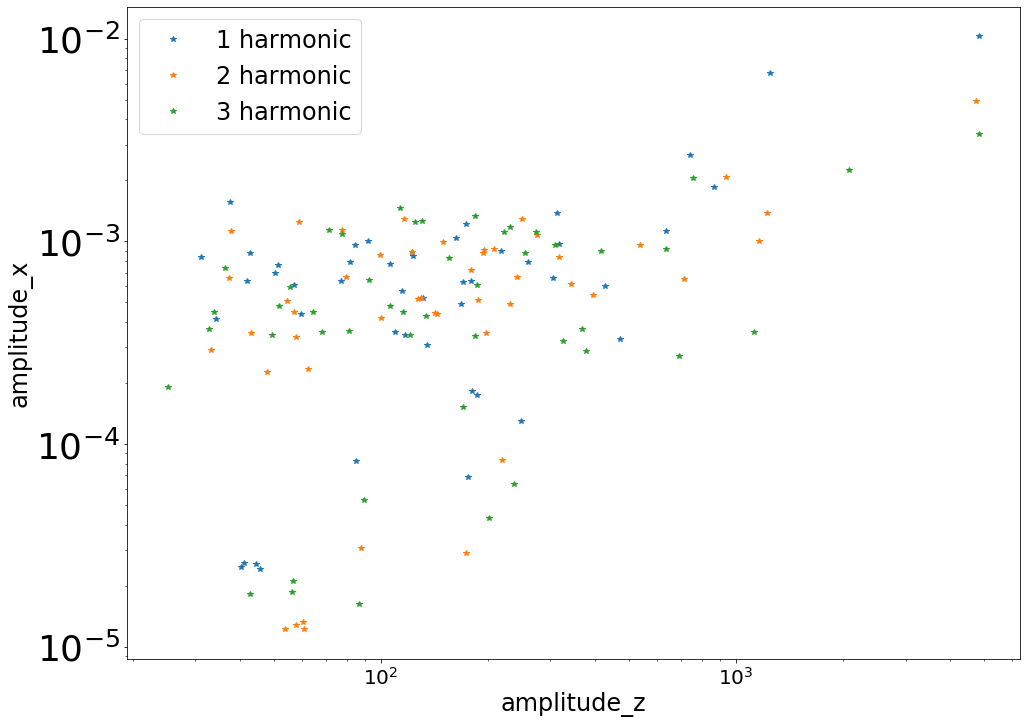

In [291]:
var_of_int1 ="amplitude_z"
var_of_int2 = "amplitude_x"
for j in np.arange(0,3,1):    
    z_attr_pos_list = []
    mean_force_z_single_harmonic = []
    for i in range(len(df_list)):
        z_attr_pos_list.append(np.mean(df_list[i][var_of_int1][j]))
        mean_force_z_single_harmonic.append(np.mean(df_list[i][var_of_int2])[j])
    plt.plot(z_attr_pos_list,mean_force_z_single_harmonic,linestyle="",marker="*",label="%d harmonic"%(j+1))
    plt.yscale("log")
    plt.xscale("log")
    plt.ylabel(var_of_int2)
    plt.xlabel(var_of_int1)
    plt.legend()
#plt.savefig("Results/Dalen_20200106/2d_%s_vs%s_all_datasets.png" %(var_of_int1,var_of_int2), dpi=300, bbox_inches="tight")
plt.show()    

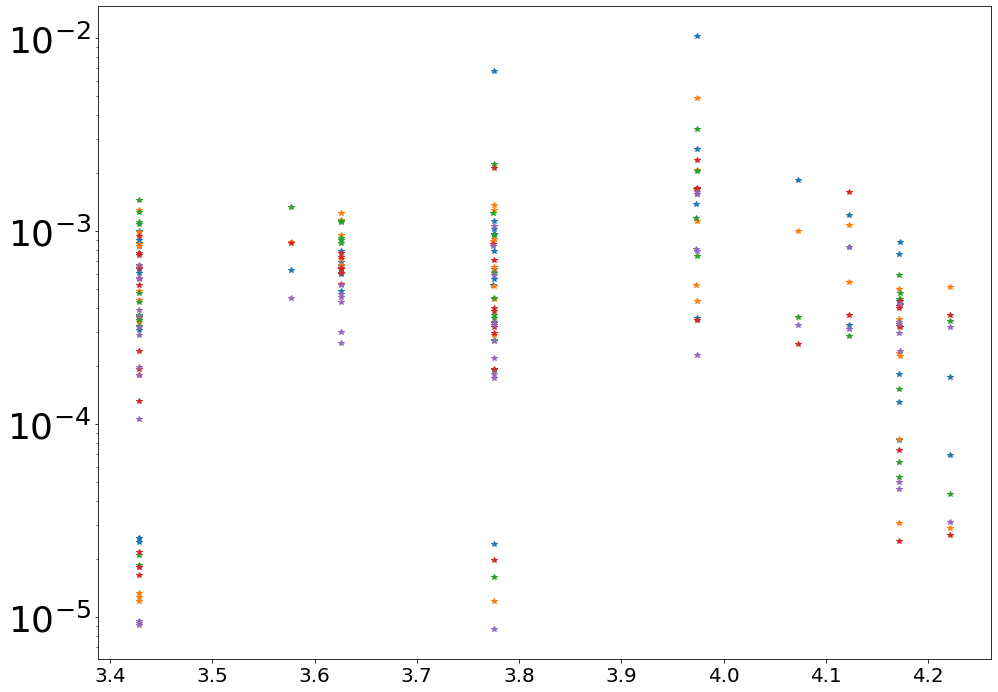

In [193]:
for j in np.arange(0,5,1):    
    z_attr_pos_list = []
    mean_force_x_single_harmonic = []
    for i in range(len(df_list)):
        z_attr_pos_list.append(np.mean(df_list[i]["attractor_position_z"]))
        mean_force_x_single_harmonic.append(np.mean(df_list[i]["amplitude_x"])[j])
    plt.plot(z_attr_pos_list,mean_force_x_single_harmonic,linestyle="",marker="*",label="%d"%(j+1))
    plt.yscale("log")
plt.show()    

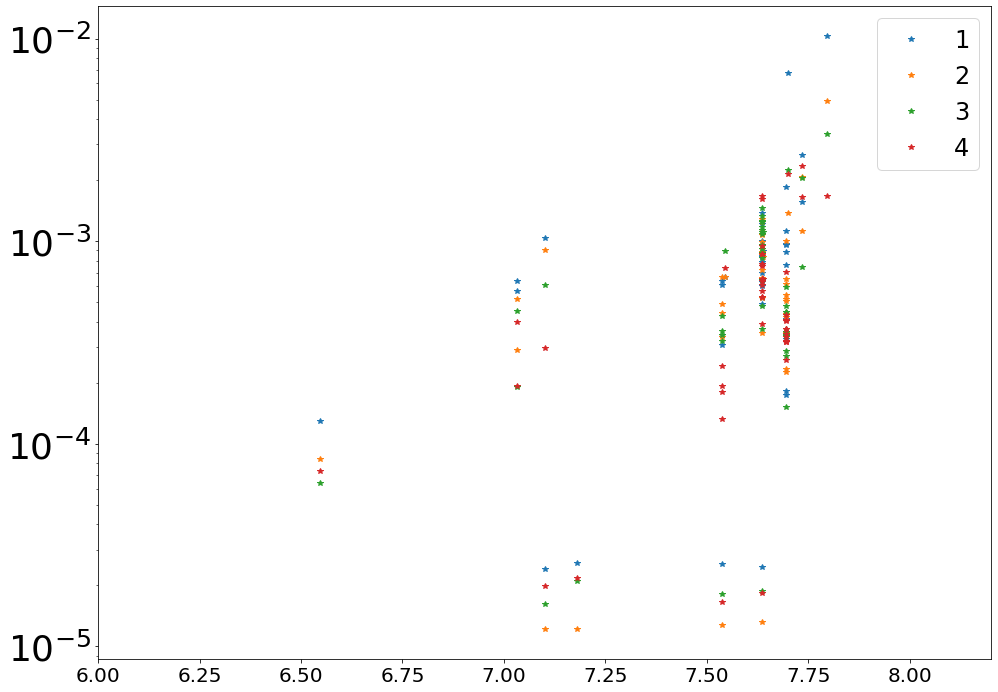

In [190]:
for j in np.arange(0,4,1):    
    x_attr_pos_list = []
    mean_force_x_single_harmonic = []
    for i in range(len(df_list)):
        x_attr_pos_list.append(np.mean(df_list[i]["attractor_position_x"]))
        mean_force_x_single_harmonic.append(np.mean(df_list[i]["amplitude_x"])[j])
    plt.plot(x_attr_pos_list,mean_force_x_single_harmonic,linestyle="",marker="*",label="%d"%(j+1))
    plt.yscale("log")
plt.xlim(6,8.2)
plt.legend()
plt.show()    


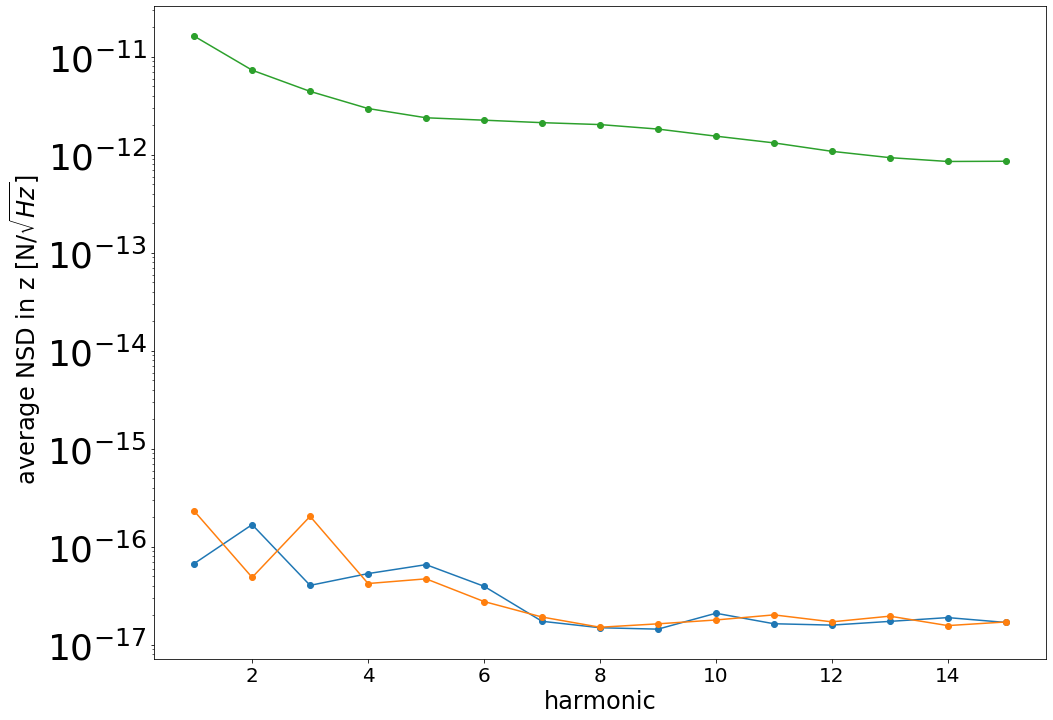

In [148]:
df_sublist = []
#df_sublist = df_list[3:7]
df_sublist.append(df_list[40][0:40])
df_sublist.append(df_list[40][40:80])
df_sublist.append(df_list[40][91:93])

axis = "z"
if(axis=="x"):norm_factor=norm_x
if(axis=="z"):norm_factor=norm_z    
distance = 393
output_file= "Results/Dalen_20200106/%sforce_shield_no_shield_390_and_%d.png" %(axis,distance)
save_file = False
plot_basic_harmonic_sum(df_sublist,axis=axis,norm_factor=norm_factor,no_harmonics=15,label="shake frequency in Hz",var_of_interest="attractor_position_x",output_file=output_file,legend=False,save_file=save_file)

KeyError: 0

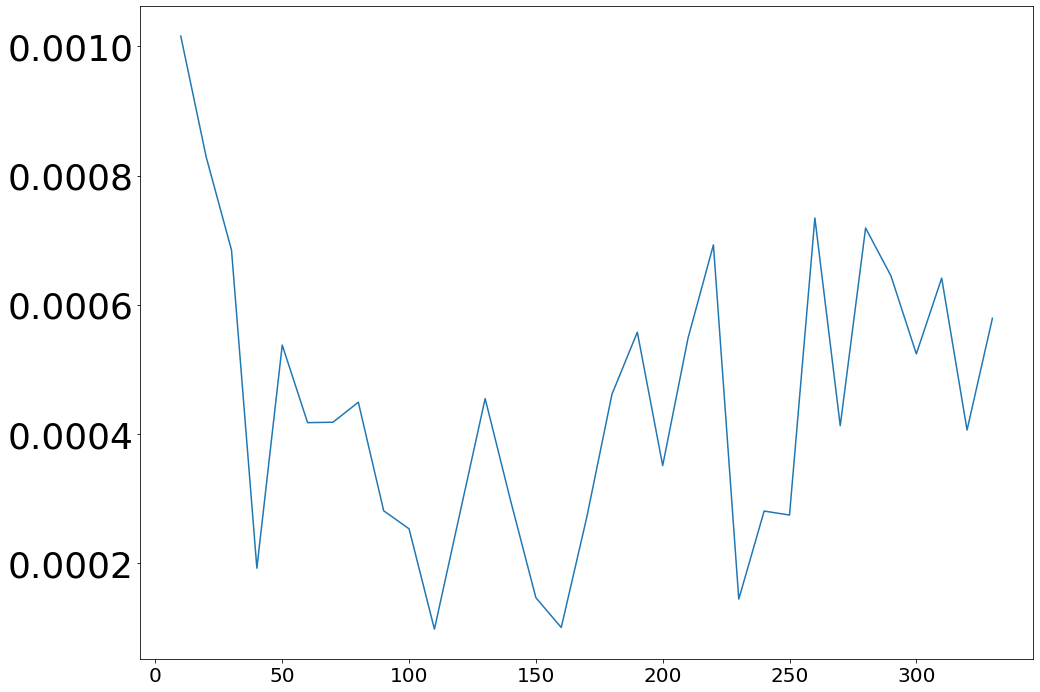

In [126]:
df_sublist =[]

plot_amplitude_vs_data_set(df_sublist,axis="x")

0.001955395628845772

686483.8732875169


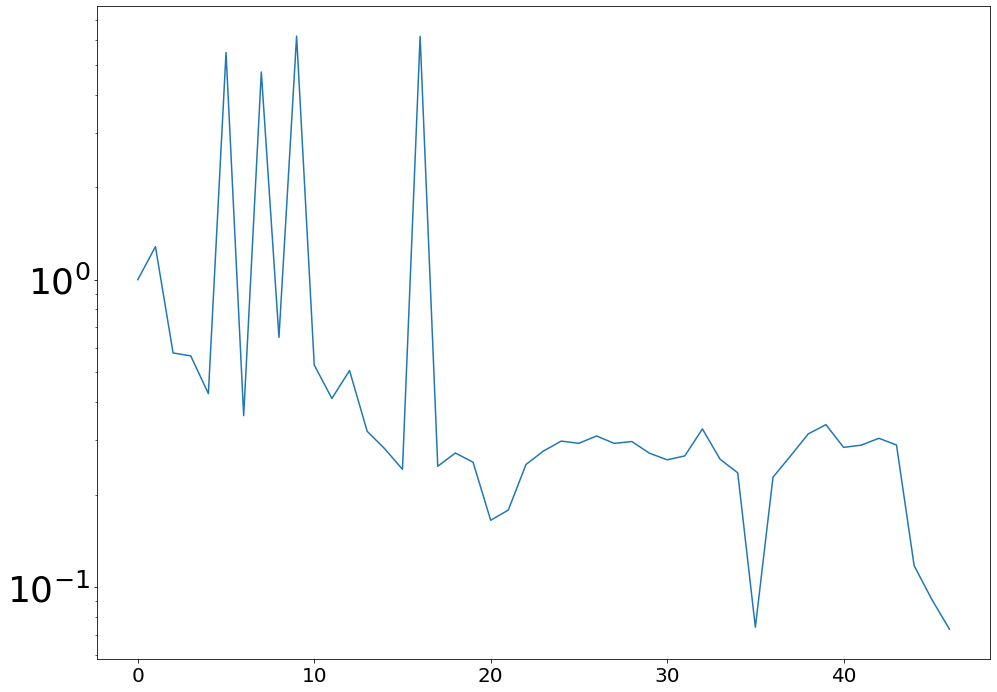

In [261]:
mean_spin =[]
df_sublist =[]
mean_val = []
x= np.arange(0,len(df_list),1)
for j in range(len(df_list)):
    mean_spin.append(10*np.mean(np.mean(df_list[j]["spin_data"])))
    mean_val.append(np.mean(np.mean(df_list[j]["amplitude_x"])))
print(mean_val[0]/mean_spin[0])
plt.plot(x,np.divide(np.divide(mean_spin,mean_spin[0]),np.divide(mean_val,mean_val[0])))
plt.yscale("log")
plt.show()

(1e-15, 1e-07)

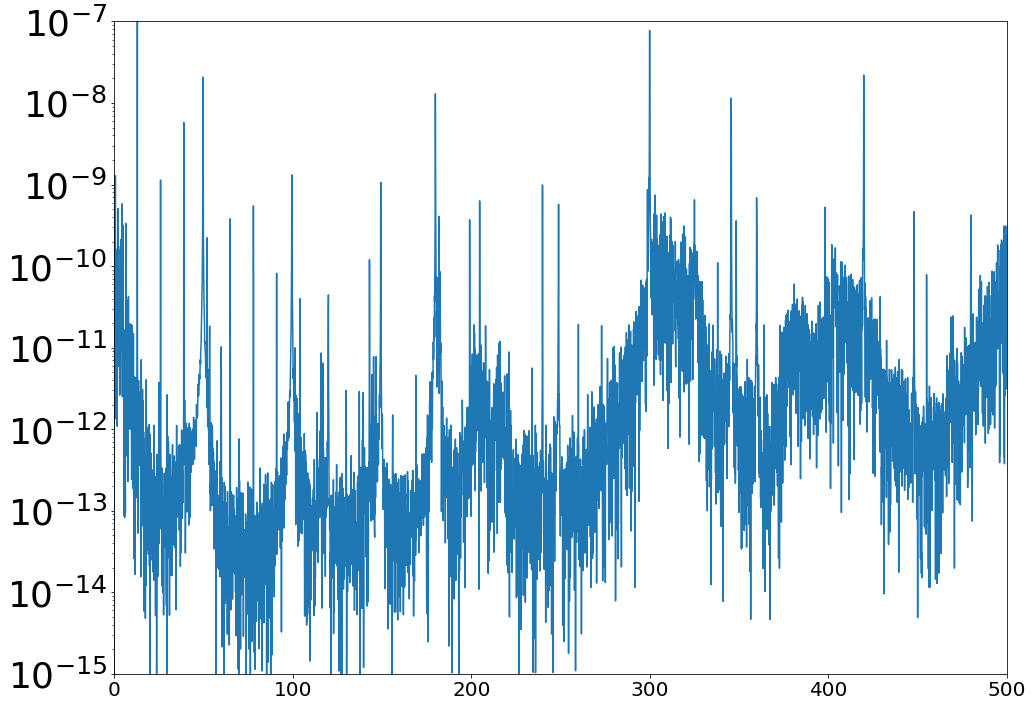

In [439]:
plt.plot(x,df_sublist[0]["spin_data"][30])
plt.yscale("log")
plt.xlim(0,500)
plt.ylim(1e-15,1e-7)

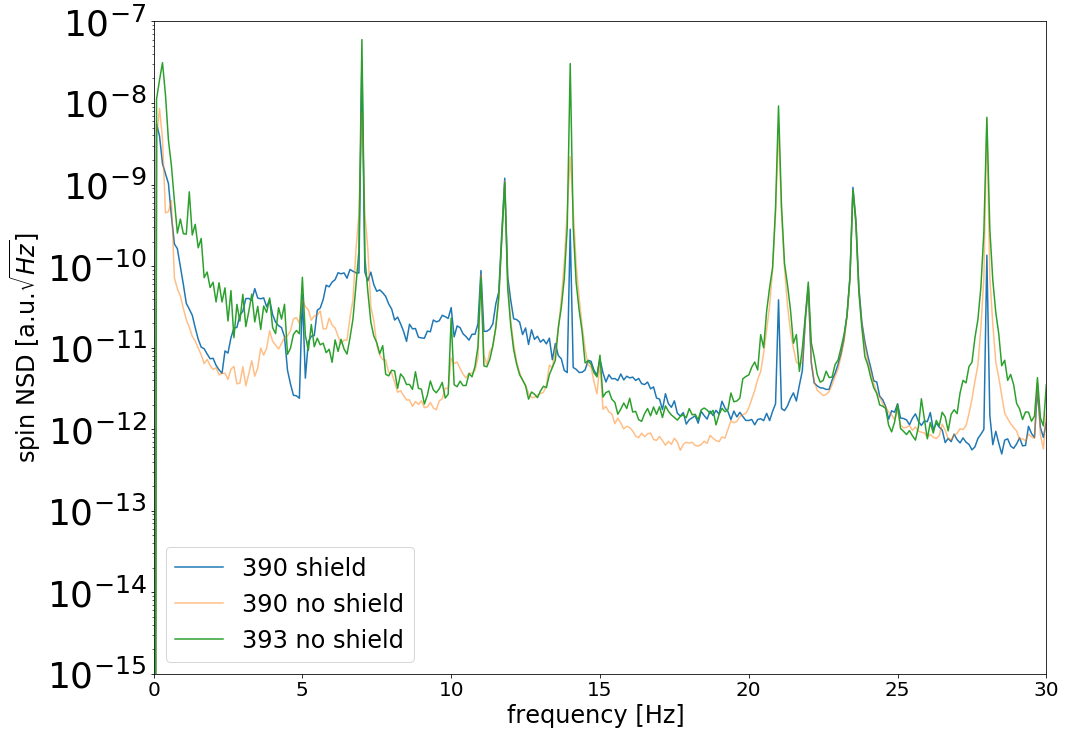

In [310]:
x = np.arange(0,2500.1,0.1)
df_sublist =[]
df_sublist.append(df_list[44])
df_sublist.append(df_list[45])
df_sublist.append(df_list[46])


plt.plot(x,np.mean(df_sublist[0]["spin_data"]),label="390 shield")
plt.plot(x,np.mean(df_sublist[1]["spin_data"]),label="390 no shield",alpha=0.5)
plt.plot(x,np.mean(df_sublist[2]["spin_data"]),label="393 no shield")

#plt.plot(x,np.mean(df_list[34]["spin_data"]),label="shield")
#plt.plot(x,np.mean(df_list[35]["spin_data"]),label="no_shield")
plt.yscale("log")
plt.ylim(1e-15,1e-7)
plt.xlim(0,30)
plt.legend()
plt.xlabel("frequency [Hz] ")
plt.ylabel("spin NSD [a.u.$\sqrt{Hz}$]")
#plt.savefig("Results/Dalen_20200106/spin_390_and_393_shield_no_shield_200_to_2500.png", dpi=300, bbox_inches="tight")
plt.show() 

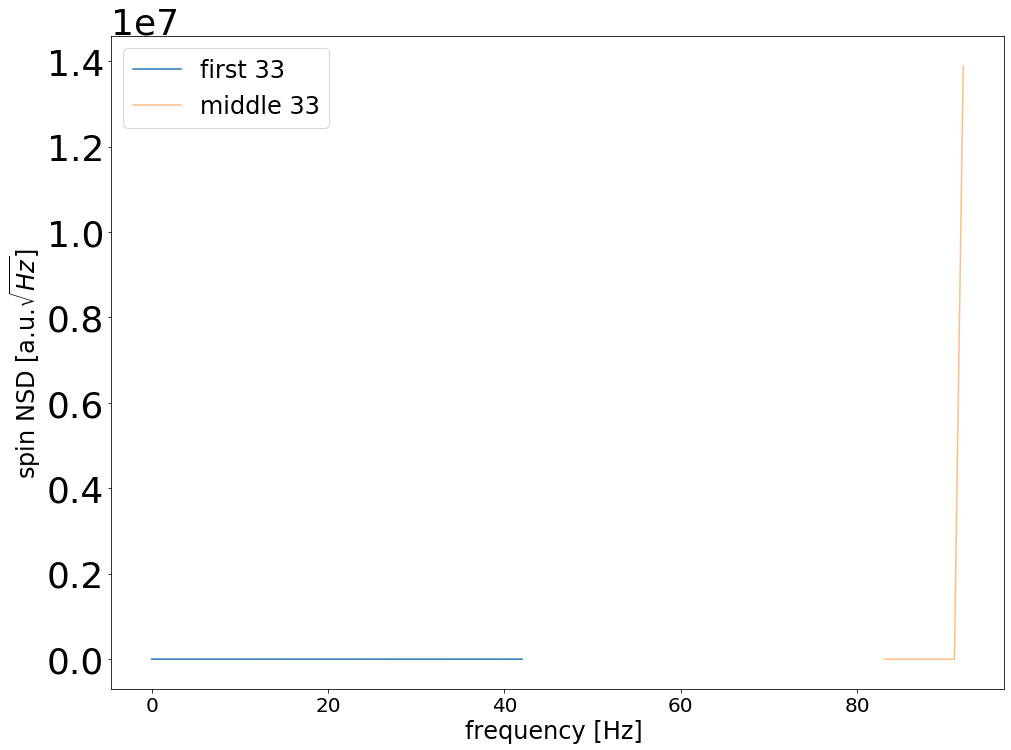

In [173]:
x = np.arange(0,2500.1,0.1)
df_sublist =[]
df_sublist.append(df_list[40][0:43])
df_sublist.append(df_list[40][83:93])

plt.plot(df_sublist[0]["z_feedback"],label="first 33")
plt.plot(df_sublist[1]["z_feedback"],label="middle 33",alpha=0.5)
#plt.plot(x,np.mean(df_sublist[2]["spin_data"]),label="last 33")

#plt.plot(x,np.mean(df_list[34]["spin_data"]),label="shield")
#plt.plot(x,np.mean(df_list[35]["spin_data"]),label="no_shield")
#plt.yscale("log")
#plt.ylim(1e-15,1e-7)
#plt.xlim(1000,2500)
plt.legend()
plt.xlabel("frequency [Hz] ")
plt.ylabel("spin NSD [a.u.$\sqrt{Hz}$]")
#plt.savefig("Results/Dalen_20200106/spin_388_shield_no_shield_full.png", dpi=300, bbox_inches="tight")
plt.show() 

In [104]:
def get_temperature_and_pressure(dates):
    airtemperature_list, surfacetemperature_list, pressure_list, f=([] for i in range(4))
    for date in dates:
        print(date)
        for i in np.arange(0,24):
            try:
                if(i<10):
                    hour = "0%d" %i
                if(i>9):
                    hour ="%d" %i
                f.append(h5py.File("/data/SC_data/TemperatureAndPressure%s/TempAndPressure%s_%s.hdf5" %(date,date,hour), mode='r+'))
            except:
                print("%s hour at %s is not on record" %(i,date))
                continue       
    for i in np.arange(0,len(f),1):
        try: 
            None
            airtemperature_list.extend(list(f[i]["AirTemperature/AirTemperatures"]))
            surfacetemperature_list.extend(list(f[i]["SurfaceTemperature/SurfaceTemperatures"]))
            pressure_list.extend(list(f[i]["Pressure/Pressures"]))
        except:
            continue
    #print(lst_dict_temp)        
    #df.append(lst_dict_temp)       
    [f_.close() for f_ in f] ## good programing
    return airtemperature_list,surfacetemperature_list, pressure_list


In [29]:
def get_temperature_and_pressure(dates,from_hour=0,to_hour=24):
    airtemperature_list, surfacetemperature_list, pressure_list, f=([] for i in range(4))
    for j in range(len(dates)):
        print(dates[j])
        for i in np.arange(from_hour,to_hour+1):
            try:
                if(i<10):
                    hour = "0%d" %i
                if(i>9):
                    hour ="%d" %i
                f.append(h5py.File("/data/SC_data/TemperatureAndPressure%s/TempAndPressure%s_%s.hdf5" %(dates[j],dates[j],hour), mode='r+'))
            except:
                print("%s hour at %s is not on record" %(i,dates[j]))
                continue       
    for i in np.arange(0,len(f),1):
        try: 
            None
            airtemperature_list.extend(list(f[i]["AirTemperature/AirTemperatures"]))
            surfacetemperature_list.extend(list(f[i]["SurfaceTemperature/SurfaceTemperatures"]))
            pressure_list.extend(list(f[i]["Pressure/Pressures"]))
        except:
            continue
    #print(lst_dict_temp)        
    #df.append(lst_dict_temp)       
    [f_.close() for f_ in f] ## good programing
    return airtemperature_list,surfacetemperature_list, pressure_list

def from_timestamp_to_temperature(start_time,end_time):
    '''
    Take the data and provide the temperature data. A lot of hacks inside.
    '''
    times=[]
    dates=[]
    from_hour =[]
    to_hour=[]
    times.append(dt.datetime.fromtimestamp(start_time/1e9))
    times.append(dt.datetime.fromtimestamp(end_time/1e9))
    time_diff=list(end_time/1e9-start_time/1e9)
    print(time_diff)
    for i in range(len(times)):
        year="%d" %times[i].year
        if(times[i].month<10):month="0"+ "%d"%times[i].month
        else:month=("%d"%times[i].month)
        if(times[i].day<10):day="0"+ "%d"%times[i].day
        else:day="%d"%times[i].day
        dates.append(year + month + day)
    dates = list(np.unique(dates))
    if(len(dates)==1):
        from_hour.append(times[0].hour)
        to_hour.append(times[-1].hour)
    else:
        from_hour.append(times[0].hour)
        to_hour.append(24)
        from_hour.append(0)
        to_hour.append(times[-1].hour)
        
    #to_hour.append([times[-1].hour if times[-1].hour>times[0].hour else 24])
    print(from_hour,to_hour)  
    env = get_temperature_and_pressure(dates,from_hour,to_hour)
    
    #to_hour = transform_time_end.hour
    #print(date,from_hour,to_hour)
    #airtemperature_list, surfacetemperature_list, pressure_list = get_temperature_and_pressure(date,from_hour,to_hour)
    starting_point = times[0].minute * 60 + times[0].second
    end_point = times[-1].minute * 60 + times[-1].second
    #print(starting_point,end_point)
    #return airtemperature_list,surfacetemperature_list,pressure_list
    print(time_diff[0])
    return env[0][starting_point:starting_point+int(time_diff[0])],env[1][starting_point:starting_point+int(time_diff[0])],env[2][starting_point:starting_point+int(time_diff[0])]#airtemperature_list[starting_point:-end_point], surfacetemperature_list[starting_point:-end_point], pressure_list[starting_point:-end_point]

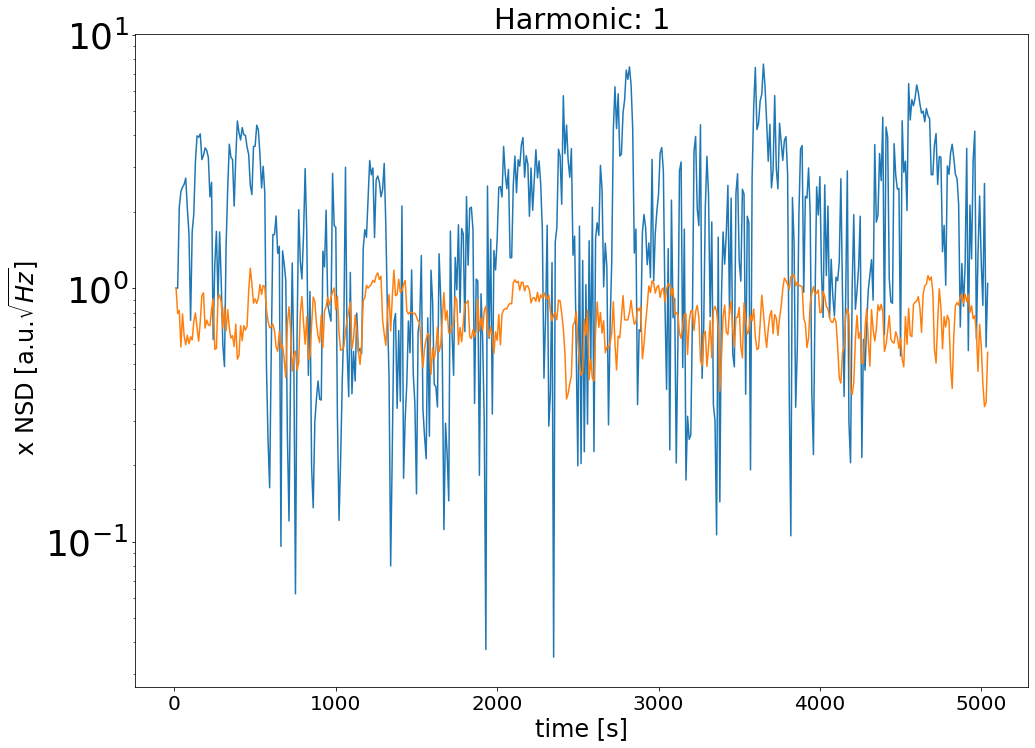

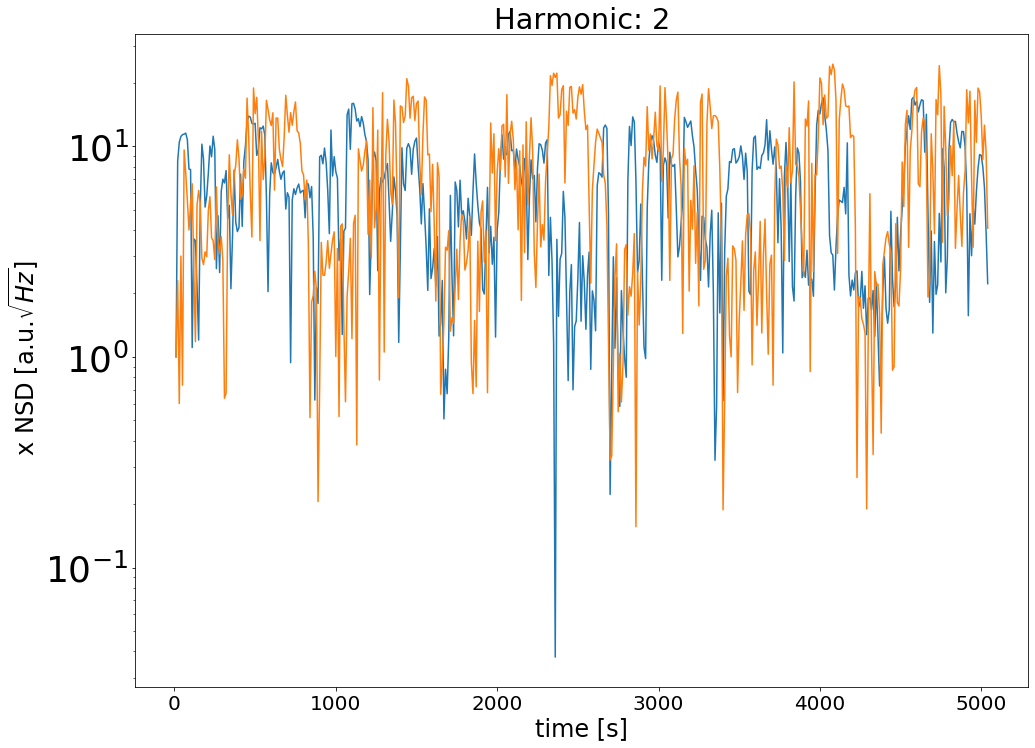

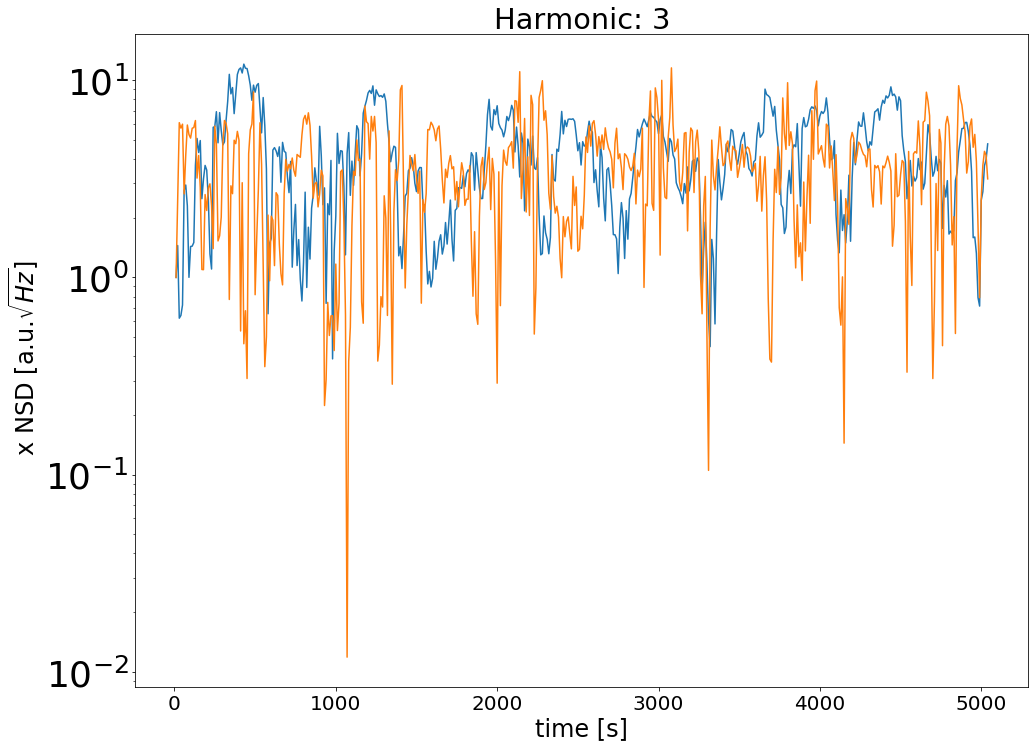

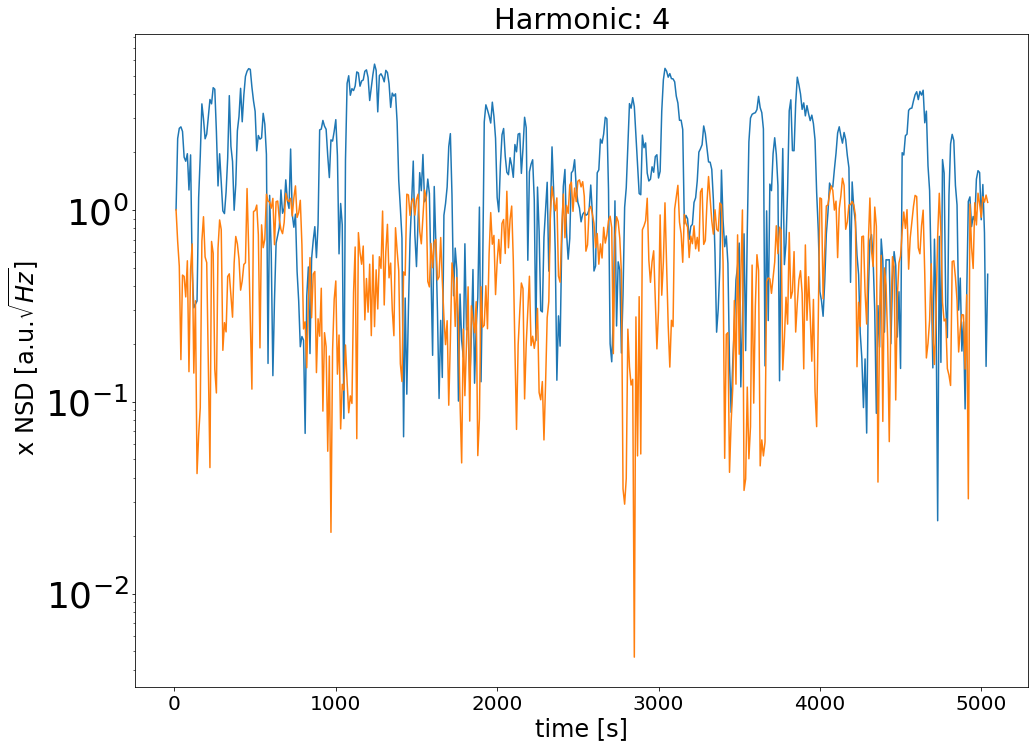

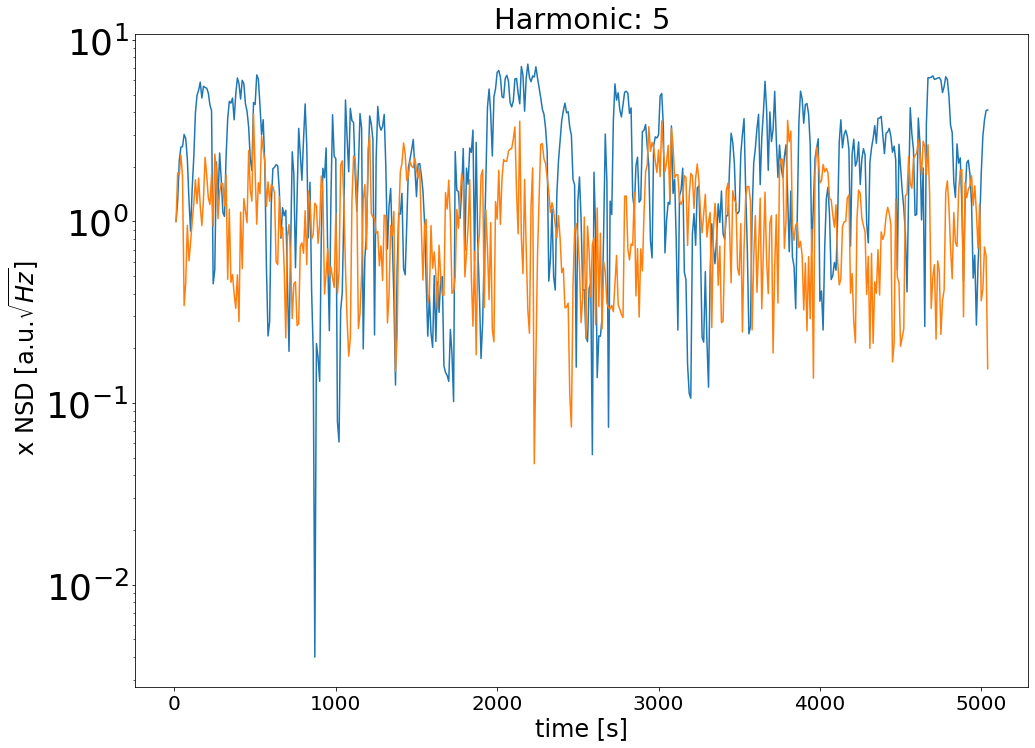

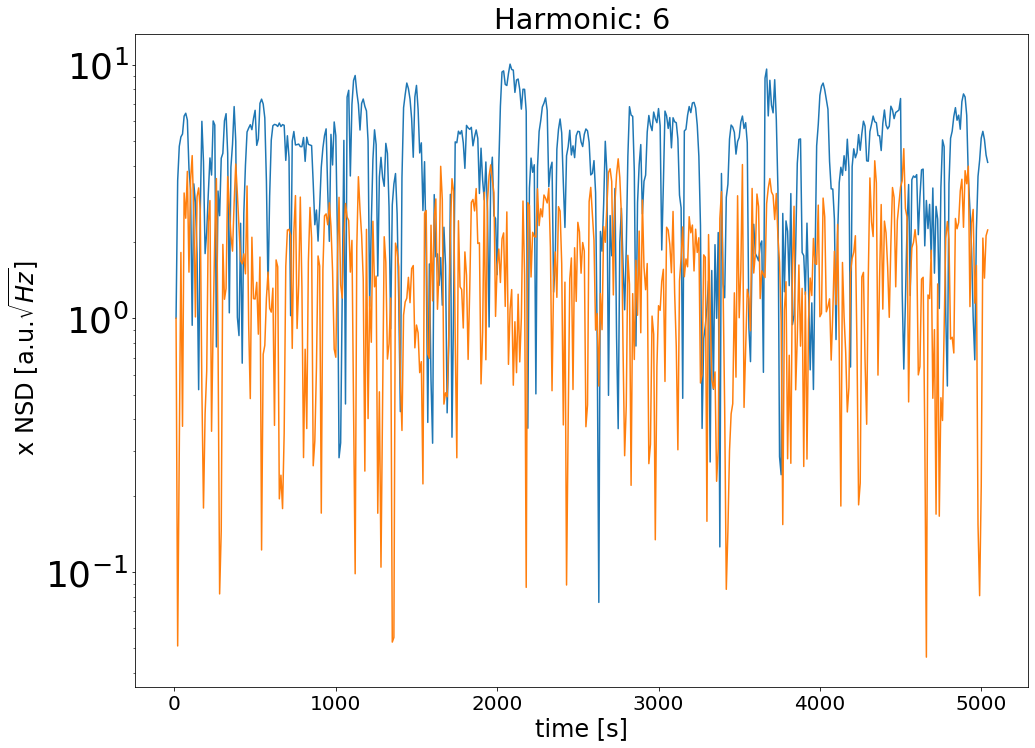

In [112]:
df = []
df.append(df_list[34][0:504])
df.append(df_list[35])
no_harmonics=6
axis="x"
axis2="z"
time=np.arange(10,len(df[0])*10+10,10)
total_outputs=[]
for k in np.arange(0,no_harmonics,1):
    for j in np.arange(0,len(df)):
        output_list=[]
        output_list2=[]
        for i in range(len(df[0])):
            output_list.append(df[j]["amplitude_%s" %axis][i][k])
            #output_list2.append(df[j]["amplitude_%s" %axis2][i][k])
        plt.plot(time,output_list/output_list[0])
        #plt.plot(time,output_list2/output_list2[0])
        #plt.plot(time,df[j]["z_feedback"]/df[j]["z_feedback"][0])
    total_outputs.append(output_list)    
    plt.title("Harmonic: %d"%(k+1))    
    plt.yscale("log")
    plt.xlabel("time [s]")
    plt.ylabel(" %s NSD [a.u.$\sqrt{Hz}$]" %axis)
    #plt.ylim(0.01*np.min(output_list),2*np.max(output_list))
    plt.show()    

In [272]:
df_list[34]["amplitude_z"][0][0]

330.24165714379717

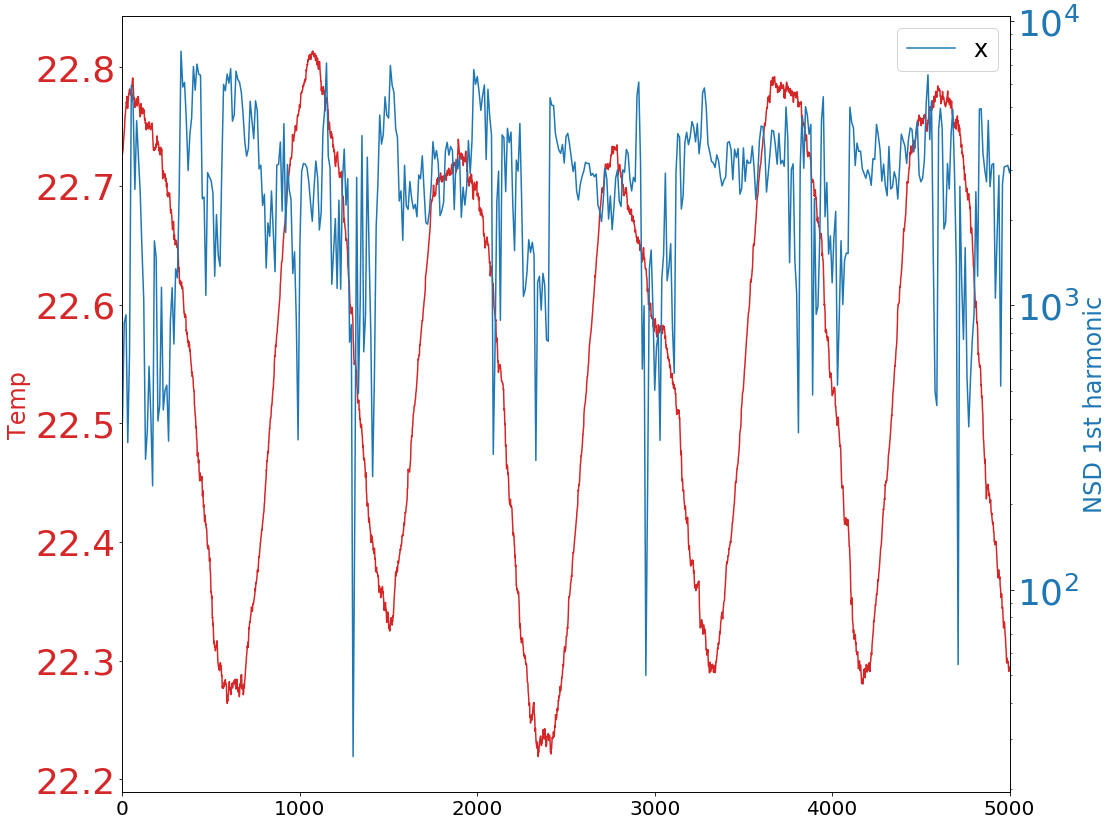

In [277]:
plt.rcParams["figure.figsize"] = (16,12)
data2=[]
data=df_list[35]
# Create some mock data
env_var = np.arange(0,len(f[0]),1)
shaking_var = np.arange(0,len(data)*10,10)
data1 = f[0]
#data1 = pressure
[data2.append(data["amplitude_z"][j][0]) for j in range(len(data))]
#data3 = df_shaking24["y_mean"]
fig, ax1 = plt.subplots()

color = 'tab:red'
#ax1.set_xlabel('time (s)')
ax1.set_ylabel('Temp', color=color)
ax1.plot(env_var, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)
#ax1.axvline(2100)
#ax1.axvline(5200)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('NSD 1st harmonic', color=color)  # we already handled the x-label with ax1
ax2.semilogy(shaking_var, data2, color=color, label = "x", alpha =1.0)
#ax2.plot(shaking_var, data3, color="g", label = "y")

ax2.tick_params(axis='y', labelcolor=color)
plt.legend()
fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig("temperature_vs_nsd.png", dpi=300, bbox_inches = "tight")
plt.xlim(0,5000)
plt.show()

In [149]:
for i in range(len(df_list)):
    if(np.mean(df_list[i]["stroke"])<10):
        print(np.mean(df_list[i]["attractor_position_z"]))

3.7752906481489505
3.7753434284806775
3.7754006614800697
3.7753750548677125
3.428124633752952
3.428068515103437


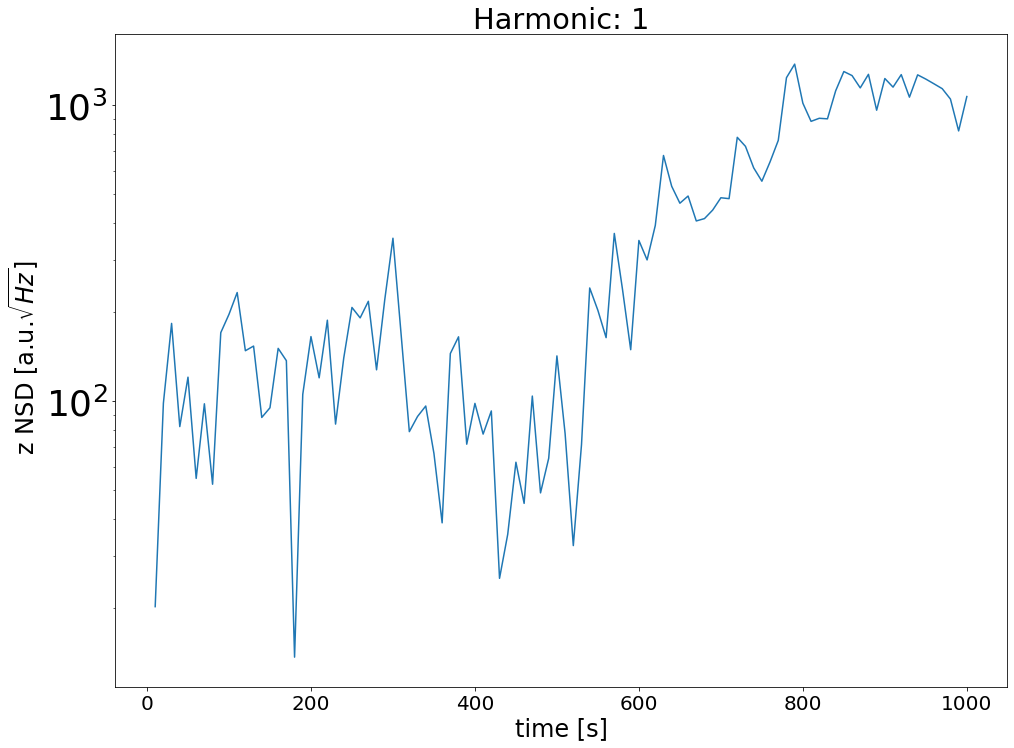

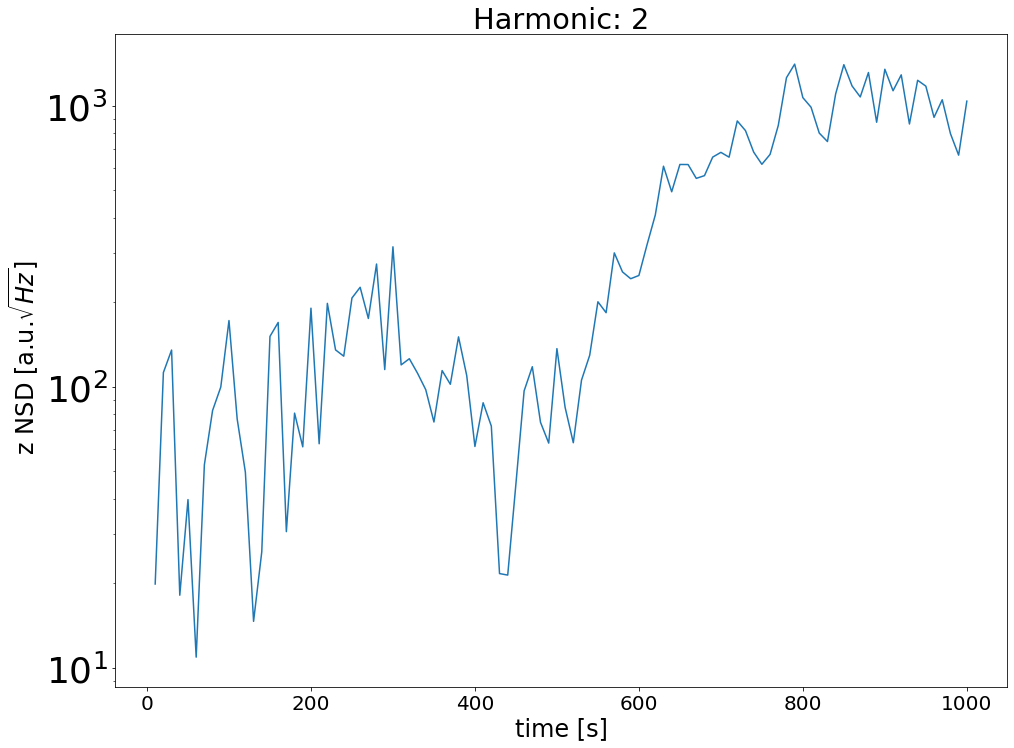

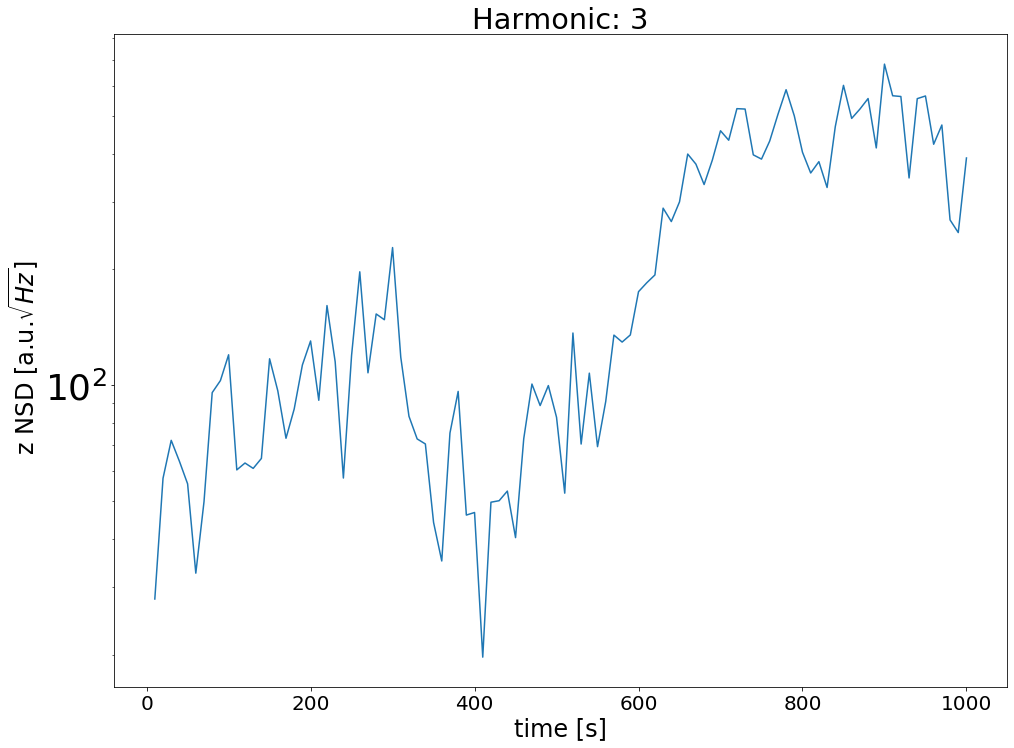

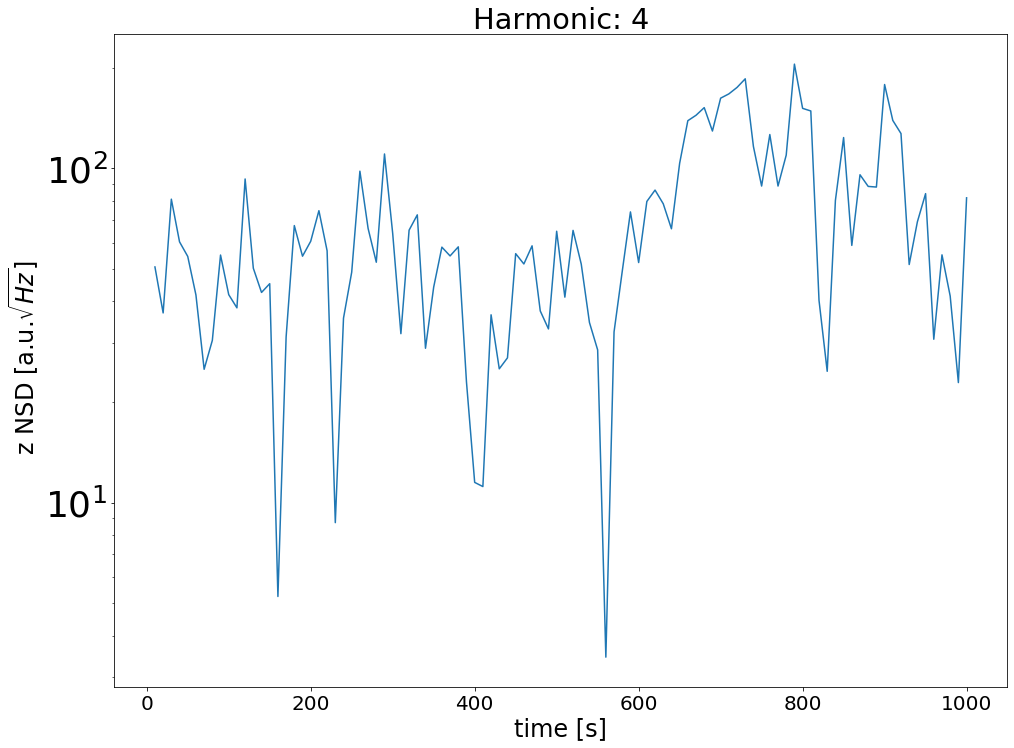

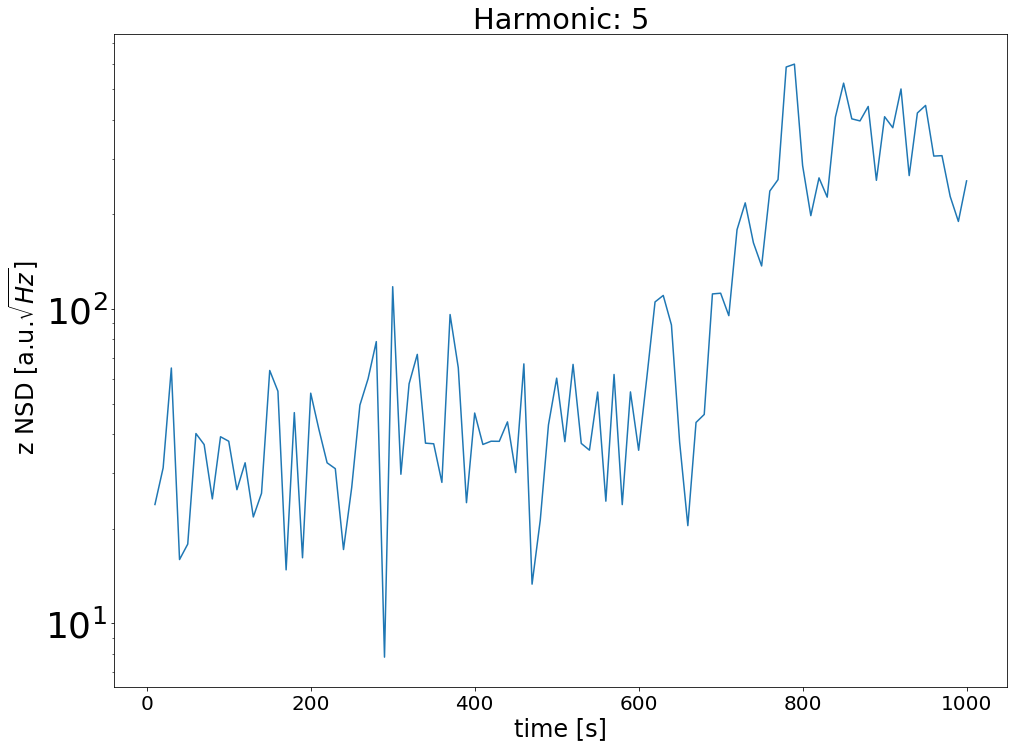

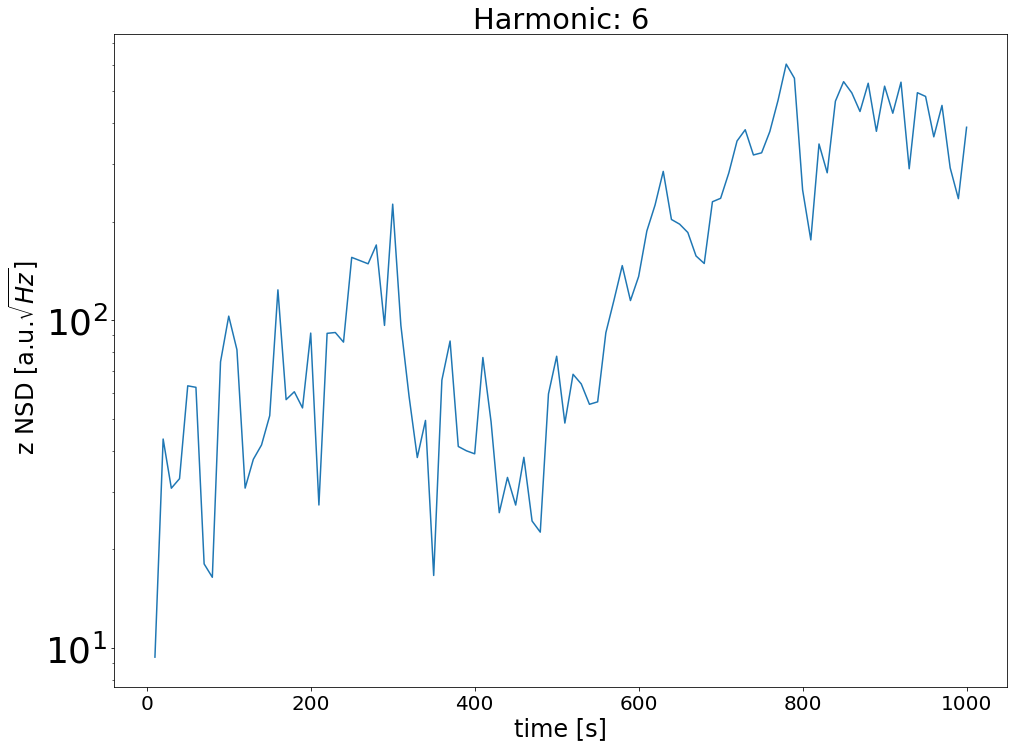

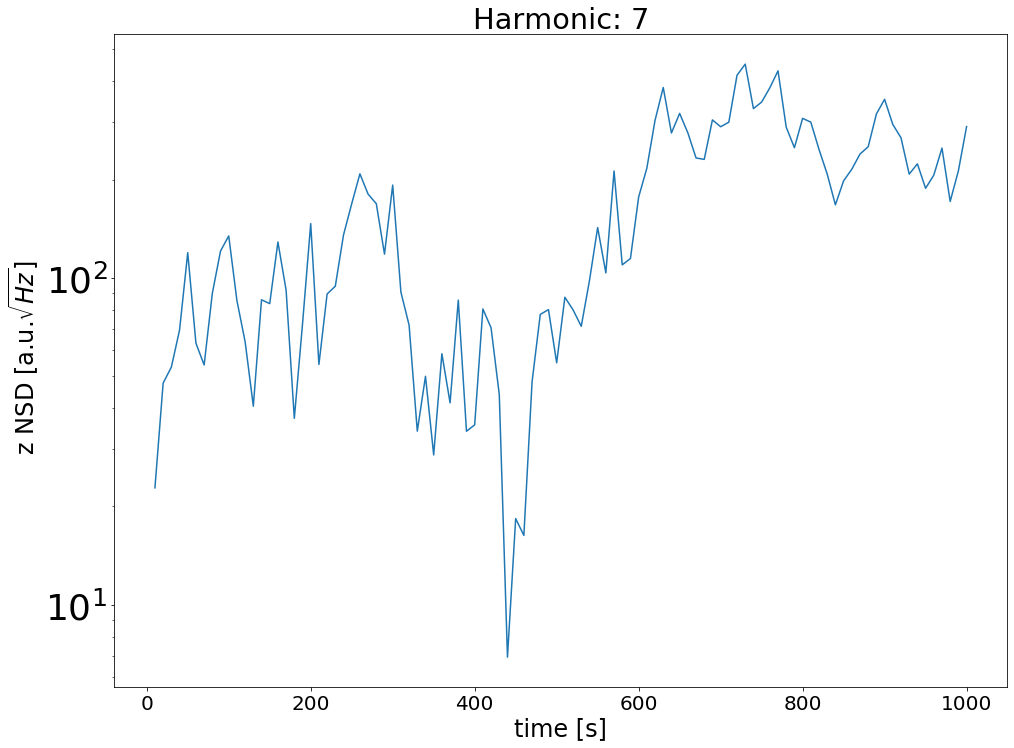

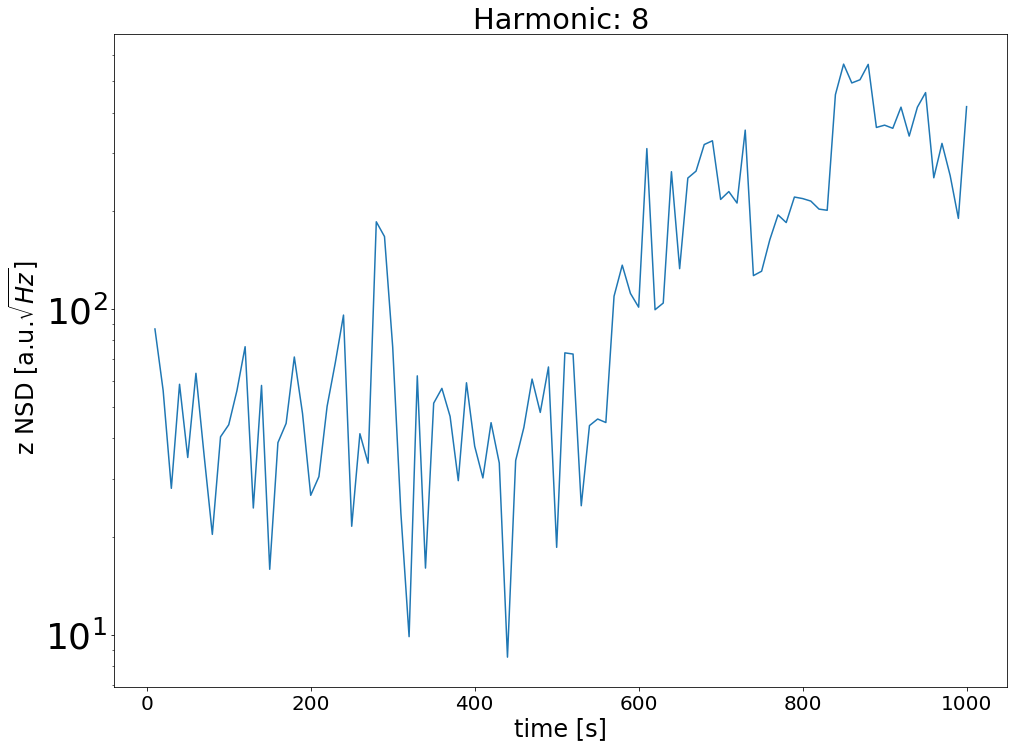

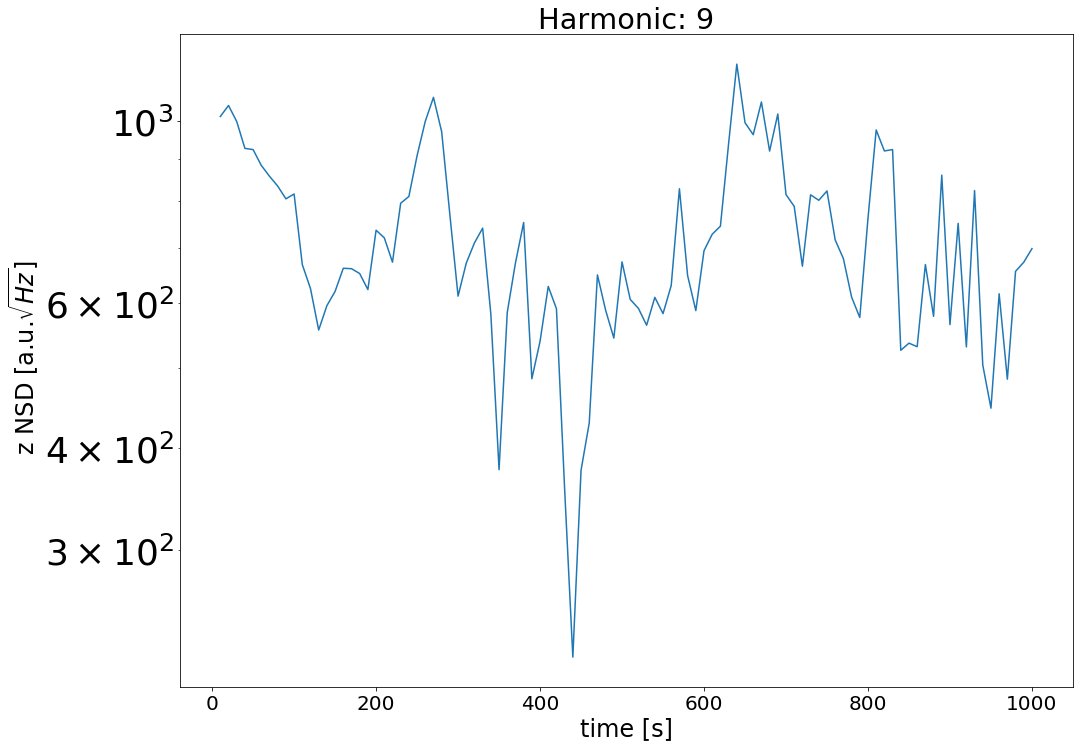

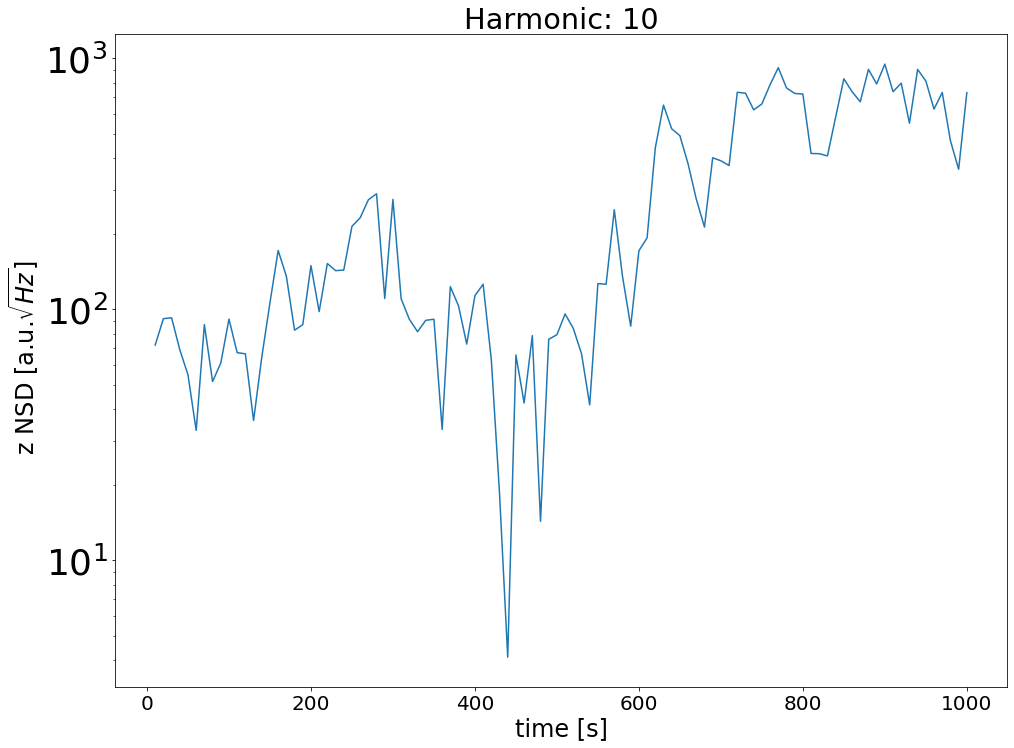

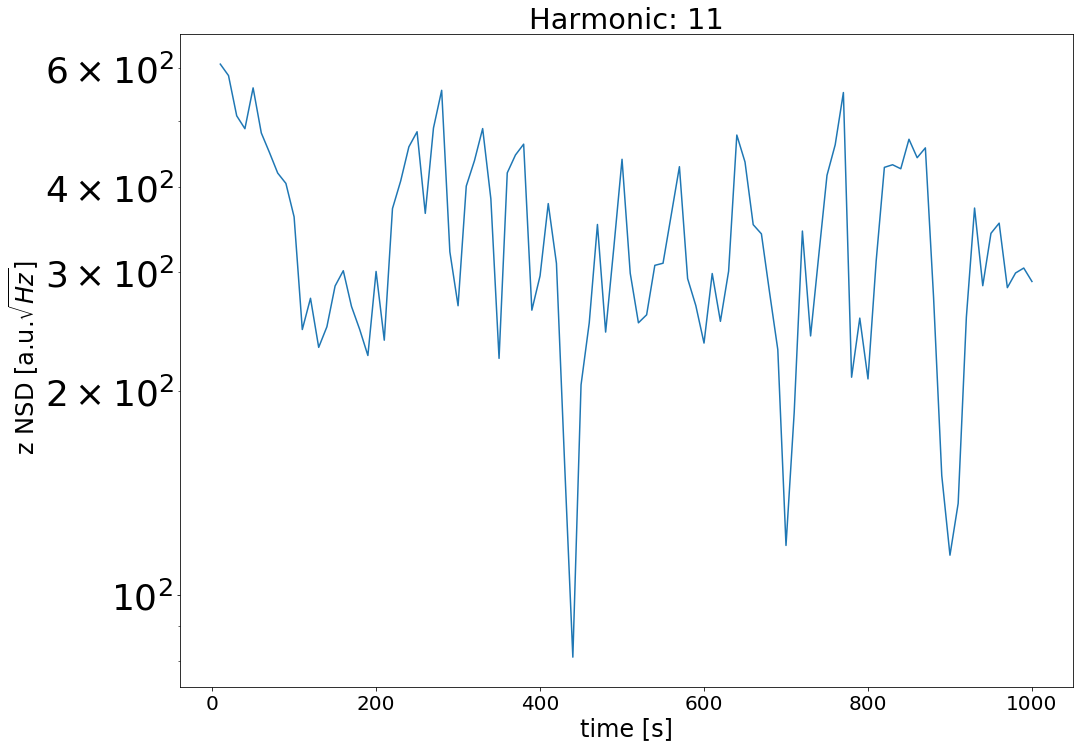

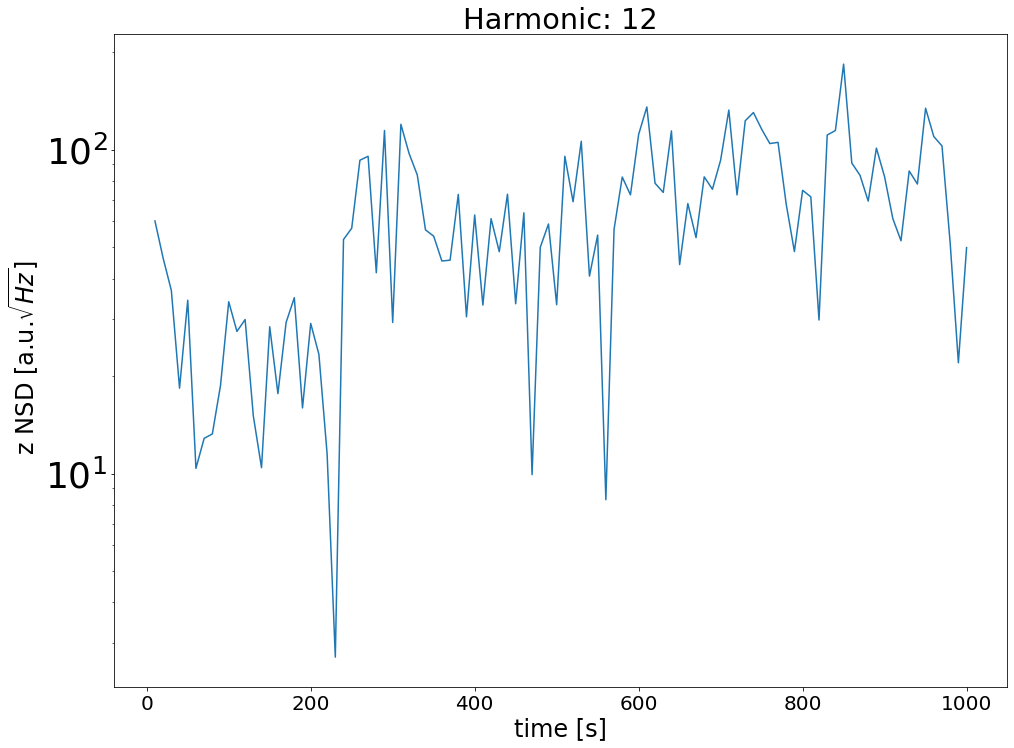

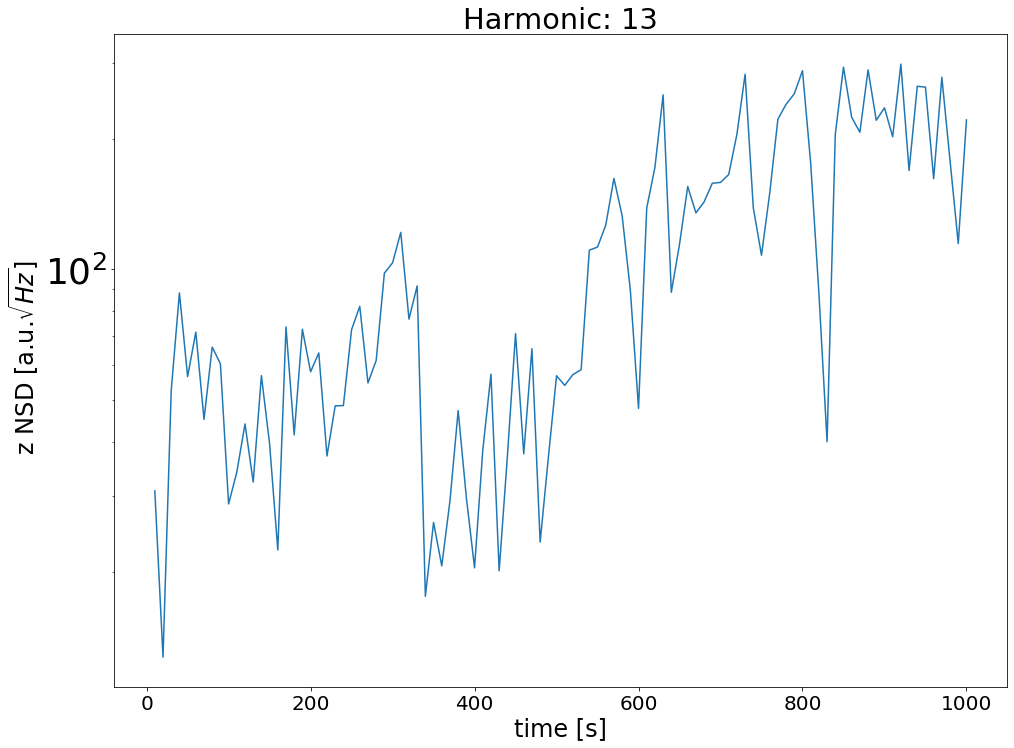

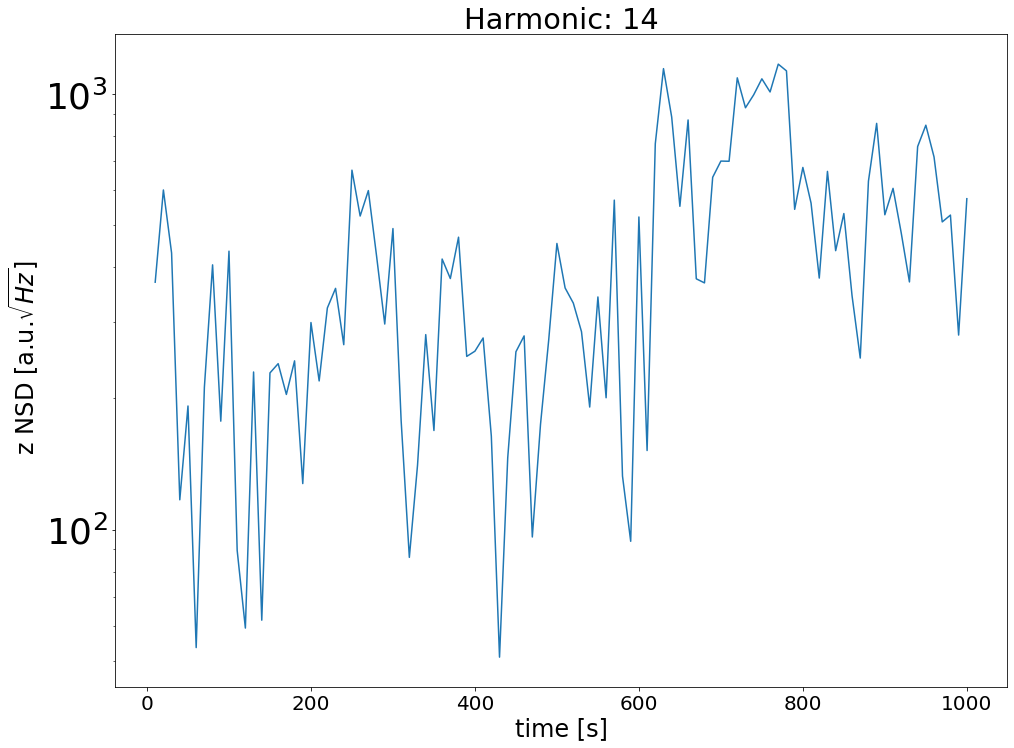

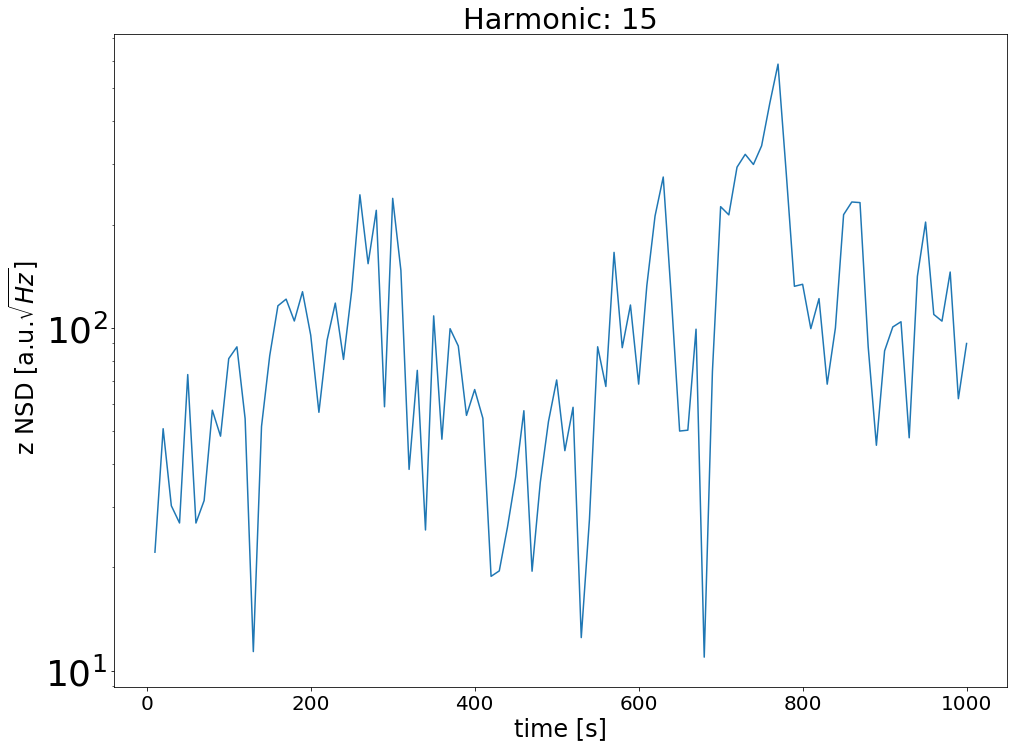

(array([  10,   20,   30,   40,   50,   60,   70,   80,   90,  100,  110,
         120,  130,  140,  150,  160,  170,  180,  190,  200,  210,  220,
         230,  240,  250,  260,  270,  280,  290,  300,  310,  320,  330,
         340,  350,  360,  370,  380,  390,  400,  410,  420,  430,  440,
         450,  460,  470,  480,  490,  500,  510,  520,  530,  540,  550,
         560,  570,  580,  590,  600,  610,  620,  630,  640,  650,  660,
         670,  680,  690,  700,  710,  720,  730,  740,  750,  760,  770,
         780,  790,  800,  810,  820,  830,  840,  850,  860,  870,  880,
         890,  900,  910,  920,  930,  940,  950,  960,  970,  980,  990,
        1000]),
 [[20.210573925121704,
   98.50819299553491,
   183.2826032086093,
   82.08704968769361,
   120.60161094021632,
   54.845740448109176,
   98.03432401130168,
   52.41334131646723,
   170.55904492037624,
   196.67547399517255,
   233.04152095876427,
   148.17332720521253,
   153.63159898538686,
   88.14567062208891,
  

In [11]:
df_sublist = []
df_sublist.append(df_list[6])
plot_amplitude_vs_data_set(df_sublist,axis="z")

In [412]:
df_list1=df_list.copy()

0


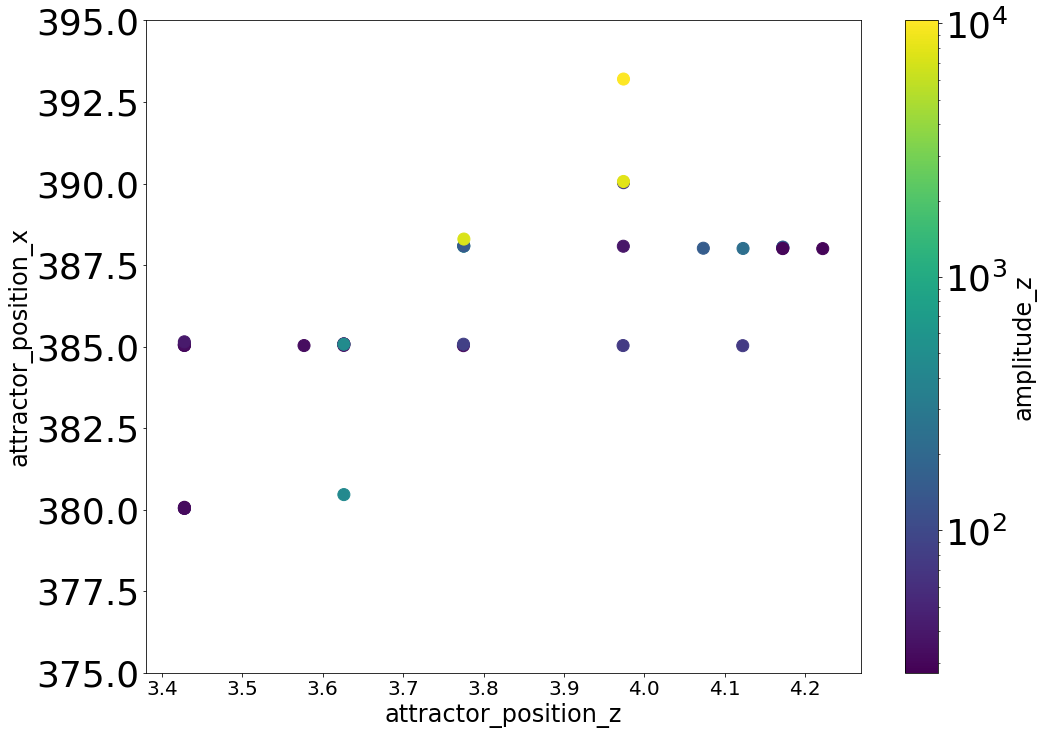

In [414]:
df_list1.pop(2)
harmonic = 3
std_list_list = []
axis1,axis2,axis3 = ([] for i in range(3))

var_of_int1="amplitude_z"
var_of_int2="attractor_position_z"
var_of_int3="attractor_position_x"

for j in range(len(df_list1)):
    std_list = []
    df=df_list1[j]
    for i in range(len(df)):
        std_list.append(df[var_of_int1][i][harmonic-1])    
    axis2.append(np.mean(std_list))
    axis1.append(np.mean(df_list1[j][var_of_int2]))
    axis3.append(voltage_to_x_position(np.mean(df_list1[j][var_of_int3])))
print(len(std_list_list))
   
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('viridis')
sc = plt.scatter(axis1,axis3,c=axis2,cmap=cm, norm=matplotlib.colors.LogNorm(),s=145)
#plt.xlim(375,400)
plt.ylim(375,395)
#plt.ylim(1e-6,1e-2)
#plt.yscale("log")
#plt.yscale("log")
plt.ylabel(var_of_int3)
plt.xlabel(var_of_int2)
plt.colorbar(sc,label=var_of_int1)
plt.savefig("3d_%s_vs_%s_vs_%s_all_but_40_and_2.png" %(var_of_int1,var_of_int2,var_of_int3), dpi=300,bbox_inches="tight")
plt.show()    

0


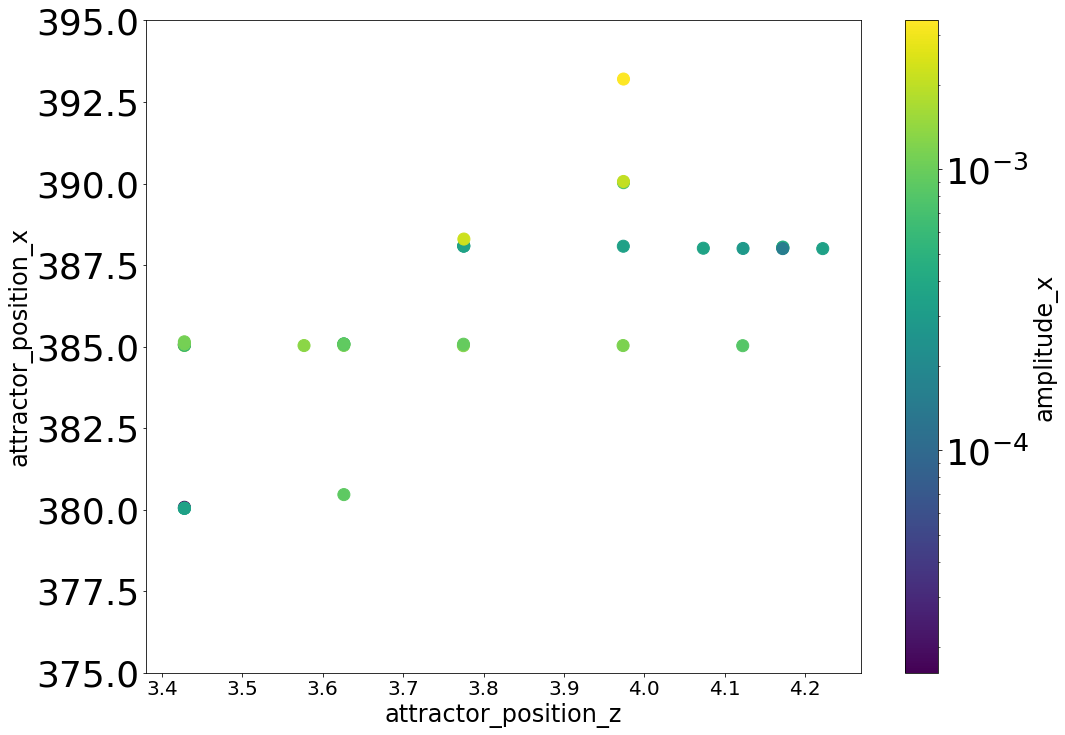

In [415]:
harmonic = 3
std_list_list = []
axis1,axis2,axis3 = ([] for i in range(3))

var_of_int1="amplitude_x"
var_of_int2="attractor_position_z"
var_of_int3="attractor_position_x"

for j in range(len(df_list1)):
    std_list = []
    df=df_list1[j]
    for i in range(len(df)):
        std_list.append(df[var_of_int1][i][harmonic-1])    
    axis2.append(np.mean(std_list))
    axis1.append(np.mean(df_list1[j][var_of_int2]))
    axis3.append(voltage_to_x_position(np.mean(df_list1[j][var_of_int3])))
print(len(std_list_list))
   
fig, ax = plt.subplots()
cm = plt.cm.get_cmap('viridis')
sc = plt.scatter(axis1,axis3,c=axis2,cmap=cm, norm=matplotlib.colors.LogNorm(),s=145)
#plt.xlim(375,400)
plt.ylim(375,395)
#plt.ylim(1e-6,1e-2)
#plt.yscale("log")
#plt.yscale("log")
plt.ylabel(var_of_int3)
plt.xlabel(var_of_int2)
plt.colorbar(sc,label=var_of_int1)
plt.savefig("3d_%s_vs_%s_vs_%s_all_but_40_and_2.png" %(var_of_int1,var_of_int2,var_of_int3), dpi=300,bbox_inches="tight")
plt.show()    